In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from google.cloud import bigquery
import os

import seaborn as sns

import ipympl
%matplotlib inline

In [2]:
#Fetches data using a BigQuery query and returns a dataframe
#Params
#-filepath to json credentials (e.g. "/Users/username/Downloads/google-analytics-x0x00x00000x.json")
#-query (e.g. """SELECT * FROM tablename""")
def fetch_bigquery_df(cred_filepath, query):
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"]=cred_filepath
    BigQuery_client = bigquery.Client()
    query_results = BigQuery_client.query(query)
    bq_df = query_results.to_dataframe()
    
    #Convert to float
    bq_df = bq_df.astype(float)
    return bq_df

In [3]:
#Fetches data from a CSV and returns a 'raw' dataframe
#Params
#-csv_filepath (e.g. 'filename.csv')
#-seperator (e.g. ';')
#-firstrow_columnnames (Boolean e.g. True) -- indicates whether the column names are in the csv file as part of the values and should be turned into column names
def csv_to_df(csv_filepath, seperator, firstrow_columnnames, remove_columns=[], keep=(0,-1)):
    csv_df = pd.read_csv(csv_filepath, sep=seperator)
    #Possibly turn first row into column names
    if firstrow_columnnames:
        csv_df.columns = csv_df.iloc[0]
        csv_df = csv_df[1:]
    
    return csv_df

In [4]:
#Prepares data
#Params
#-csv_df (dataframe e.g. df)
#-remove_columns (list e.g. ['Row Labels', 'Grand Total']) -- if not set, nothing removed
#-keep (Tuple e.g. (1, -1)) -- if not set, everything kept
def df_prep(csv_df, remove_columns=[], keep=(0,-1)):
    
    if len(remove_columns) > 0:
        csv_df = csv_df.drop(remove_columns, axis=1)
    #Possibly keep only some rows from dataframe
    #csv_df = csv_df[from:to] (e.g. keep everything but first and last two rows csv_df[1:-2]
    csv_df = csv_df[keep[0]:keep[1]]
    
    #Convert to float
    csv_df = csv_df.astype(float)
    return csv_df

In [5]:
#Feature scaling (https://scikit-learn.org/stable/modules/preprocessing.html)
#Returns a new dataframe with scaled values
#Params
#-df_scale (dataframe e.g. df)
#-columns (list e.g. categorieslist)
def scale(df_scale, columns):
    sc_dfa = StandardScaler()
    data_std = sc_dfa.fit_transform(df_scale.astype(float))
    df_std = pd.DataFrame(data_std, columns=columns)
    return df_std

In [6]:
#Gets one column from a dataframe and returns it as a dataframe 
#Params
#-raw_df (dataframe e.g. df)
#-column_name (string e.g. 'userIDs')
def getcolumn_df(raw_df, column_name):
    return pd.DataFrame(raw_df[column_name])

In [7]:
#Apply a function to all values in a set of columns of dataframe
#Params
#-df_fun (dataframe e.g. df)
#-columns (list e.g. ['A', 'B'])
#-function (def e.g. multiply)
def apply_fun(df_fun, columns, function):
    for col in columns:
        df_fun[col] = df_fun[col].apply(lambda x: function(x))

In [8]:
#Plots a heatmap of a given dataframe
#Params
#-df_hm (dataframe e.g. df)
#-xlabel (string e.g. "Income")
#-ylabel (string e.g. "Age")
#-title (string e.g. "Income per age")
def plot_heatmap(df_hm, xlabel=None, ylabel=None, title=None):
    plt.rcParams["figure.figsize"] = (16, 12)
    sh_total = sns.heatmap(df_hm, cmap="Greens", annot=True, fmt='.4f')
    sh_total.set(xlabel=xlabel, ylabel=ylabel, title = title)
    plt.show()

In [9]:
#Plots a barchart using the given X and Y values
#Params
#-x_values (list e.g. [1,2,3])
#-y-values (list e.g. [0.5, 2.5, 3.0])
def plot_barchart(x_values, y_values, xlabel=None, ylabel=None, title=None):
    plt.clf()
    plt.bar(x_values, y_values)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(x_values)
    plt.title(title)
    plt.show()

In [10]:
#Plot the explained variance ratio for different number of components in PCA
#Params
#-df_ready (dataframe e.g. df)
#-n (int e.g. 10) -- determines maximum nr of components to calculate explained variance ratio for)
def pca_nr_test(df_ready, n):
    variance = []
    for i in range(1,n+1):
        pca = PCA(n_components=i)
        pca.fit_transform(df_ready)
        variance.append(np.sum(pca.explained_variance_ratio_))
    plot_barchart(np.arange(1,n+1), variance, "nr of components", "variance %", "PCA explained variance ratio for different nr of components")

In [11]:
#Calculate the PCA values for a certain number of components on a given dataframe and return a dataframe with PCA values
#Params
#-df_ready (dataframe e.g. df)
#-n (int e.g. 10) -- number of components for PCA, determined by plotting explained variance for each n
def get_pca_df(df_ready, n):
    pca = PCA(n_components=n)
    pca.fit_transform(df_ready)
    indices = []
    for i in range(1,n+1):
        indices.append("PC_"+str(i))
    dataset_pca = pd.DataFrame(abs(pca.components_), columns=df_ready.columns, index=indices)
    return dataset_pca.T

In [12]:
#Return for which Principal Component a row has the lowest Mean Squared Error and to which PC it should be assigned
#Params
#row (row in dataframe)
#df_pca (dataframe e.g. df) -- calculated PCA dataframe
def lowest_mse_index(row, df_pca):
    df_pca = df_pca.T
    minim = 100000.0
    result = 0
    for i in range(len(df_pca)):
        pc = df_pca.iloc[i]
        mse = (np.square(pc-row)).mean(axis=0)
        if mse<minim:
            minim=mse
            result=i+1
    return result

In [13]:
#Assign a principal component nr to each row in a dataframe, based on the previously calculated PCA dataframe
#Params
#-df_ready (dataframe e.g. df) -- prepared (and thus scaled) dataframe
#-df_pca (dataframe e.g. df) -- previously calculated PCA dataframe
def assign_pc(df_ready, df_pca):
    df_result = df_ready
    df_result['pc'] = df_result.apply(lambda row: lowest_mse_index(row,df_pca), axis=1)
    return df_result

In [14]:
#Return number of occurrences per value in a certain column
#Params
#-df (dataframe e.g. df)
#-column_name (string e.g. 'pc') -- column to find spread in
def spread_in_column(df, column_name='pc'):
    return df[column_name].value_counts()

In [15]:
#1) Data collection
raw_df = csv_to_df('user-category-interactions.csv', ';', True)

#2) Data preparation
prepped_df = df_prep(raw_df, ['Row Labels', 'Grand Total'])
categories = prepped_df.columns.values.tolist()

df_std = scale(prepped_df, categories)

#Prepared dataframe with columns for each category and rows per userID
df_std

,A,B,C,D,E,F,G,H,I,J,K,L
0,-0.182363,-0.158817,-0.145248,-0.086285,-0.041367,0.655894,1.160467,1.229844,-0.422883,-0.091792,-0.119343,-0.042762
1,-0.182363,-0.158817,-0.145248,1.778480,-0.041367,-0.454562,-0.320051,-0.274978,2.573729,-0.091792,-0.119343,-0.042762
2,-0.182363,-0.158817,-0.145248,-0.086285,-0.041367,-0.454562,-0.320051,-0.274978,0.176440,-0.091792,-0.119343,-0.042762
3,-0.182363,2.452360,3.864035,3.643244,-0.041367,7.318627,1.160467,1.229844,0.176440,-0.091792,-0.119343,-0.042762
4,-0.182363,-0.158817,-0.145248,0.846097,-0.041367,0.100666,1.160467,-0.274978,0.176440,-0.091792,-0.119343,-0.042762
...,...,...,...,...,...,...,...,...,...,...,...,...
15080,-0.182363,-0.158817,-0.145248,-0.086285,-0.041367,0.100666,1.160467,0.477433,-0.422883,-0.091792,-0.119343,-0.042762
15081,-0.182363,-0.158817,-0.145248,-0.086285,-0.041367,-0.454562,-0.320051,-0.274978,0.176440,-0.091792,2.963353,-0.042762
15082,-0.182363,-0.158817,-0.145248,-0.086285,-0.041367,0.655894,-0.320051,0.477433,-0.422883,-0.091792,-0.119343,-0.042762
15083,-0.182363,-0.158817,-0.145248,0.379906,-0.041367,1.211122,-0.320051,0.477433,-0.422883,-0.091792,-0.119343,-0.042762


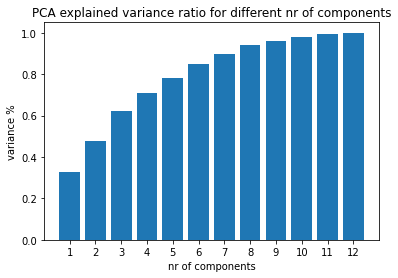

In [16]:
#3) Choosing a number of components for PCA
#Find nr of components for PCA based on explained variance
pca_nr_test(df_std, 12)

In [17]:
#4) Performing PCA and visualising it
pca_df = get_pca_df(df_std, 6)

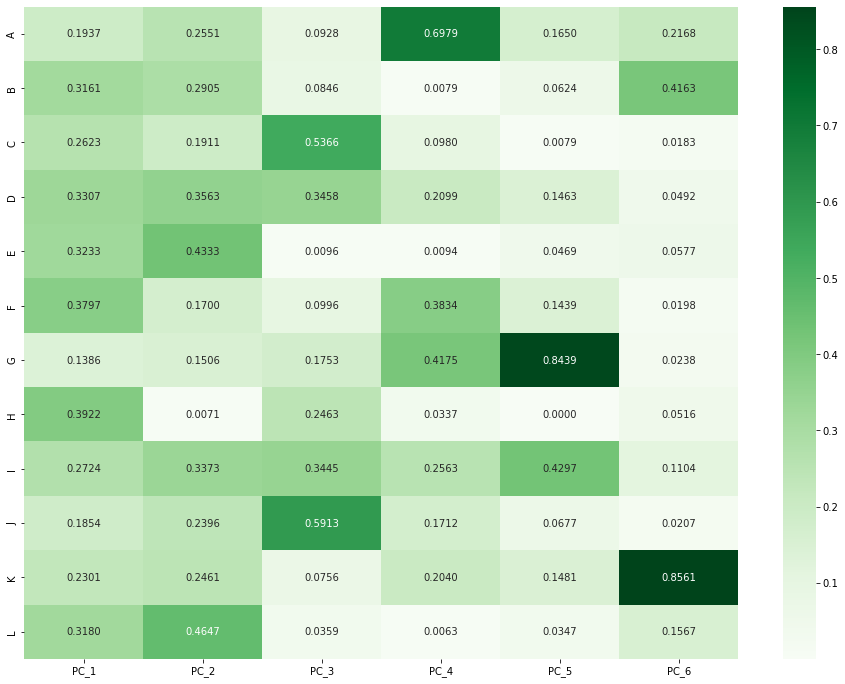

In [18]:
plot_heatmap(pca_df)

In [19]:
#5) Assigning each user to a cluster
labelled_df = assign_pc(df_std, pca_df)

In [20]:
#Show the spread over each pc
spread_in_column(labelled_df)

6    7912
5    2076
2    1827
1    1636
4    1030
3     604
Name: pc, dtype: int64

In [21]:
#Create dataframe with assigned pc per user
labelled_df['userids'] = getcolumn_df(raw_df, 'Row Labels')
labelled_df

,A,B,C,D,E,F,G,H,I,J,K,L,pc,userids
0,-0.182363,-0.158817,-0.145248,-0.086285,-0.041367,0.655894,1.160467,1.229844,-0.422883,-0.091792,-0.119343,-0.042762,5,NaN
1,-0.182363,-0.158817,-0.145248,1.778480,-0.041367,-0.454562,-0.320051,-0.274978,2.573729,-0.091792,-0.119343,-0.042762,2,1
2,-0.182363,-0.158817,-0.145248,-0.086285,-0.041367,-0.454562,-0.320051,-0.274978,0.176440,-0.091792,-0.119343,-0.042762,6,2
3,-0.182363,2.452360,3.864035,3.643244,-0.041367,7.318627,1.160467,1.229844,0.176440,-0.091792,-0.119343,-0.042762,1,3
4,-0.182363,-0.158817,-0.145248,0.846097,-0.041367,0.100666,1.160467,-0.274978,0.176440,-0.091792,-0.119343,-0.042762,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15080,-0.182363,-0.158817,-0.145248,-0.086285,-0.041367,0.100666,1.160467,0.477433,-0.422883,-0.091792,-0.119343,-0.042762,5,15080
15081,-0.182363,-0.158817,-0.145248,-0.086285,-0.041367,-0.454562,-0.320051,-0.274978,0.176440,-0.091792,2.963353,-0.042762,6,15081
15082,-0.182363,-0.158817,-0.145248,-0.086285,-0.041367,0.655894,-0.320051,0.477433,-0.422883,-0.091792,-0.119343,-0.042762,1,15082
15083,-0.182363,-0.158817,-0.145248,0.379906,-0.041367,1.211122,-0.320051,0.477433,-0.422883,-0.091792,-0.119343,-0.042762,1,15083


In [22]:
#Create CSV for further use
labelled_df.to_csv('pca-result.csv')